In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [2]:
## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        self.pullsNum = np.zeros(narms)
        self.values = np.full(narms, Q0)
        
    def play(self, tround, context=None):
        # tround not used in this implementation of MAB
        rand = np.random.random()
        # if rand < epsilon, pick random arm (explore), otherwise pick best arm (exploit) (with random tiebreak)
        if rand < self.epsilon:
            return np.random.randint(self.narms)
        else:
            maxValue = max(self.values)
            bestArms = [i for i, value in enumerate(self.values) if value == maxValue]
            return np.random.choice(bestArms)
        
    def update(self, arm, reward, context=None):
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            self.values[arm] = (self.values[arm] * self.pullsNum[arm] + reward) / (self.pullsNum[arm] + 1)
        self.pullsNum[arm] += 1
    

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        self.narms = narms
        self.rho = rho
        self.Q0 = Q0
        self.pullsNum = np.zeros(narms)
        self.values = np.full(narms, Q0)
    
    def play(self, tround, context=None):
        # compute the sum of average reward and confidence interval for each arm
        estimatedValues = [0] * self.narms
        for i in range(self.narms):
            avg_arm_value = self.values[i]
            if avg_arm_value == self.Q0:
                estimatedValues[i] = self.Q0
            else:
                confidence_interval = np.sqrt((self.rho * np.log(tround)) / self.pullsNum[i])
                estimatedValues[i] = avg_arm_value + confidence_interval
        
        # choose randomly between arms with max sum of avg reward and confidence interval
        maxValue = max(estimatedValues)
        bestArms = [i for i, value in enumerate(estimatedValues) if value == maxValue]
        return np.random.choice(bestArms)
        
    def update(self, arm, reward, context=None):
        if self.values[arm] == self.Q0:
            self.values[arm] = reward
        else:
            self.values[arm] = (self.values[arm] * self.pullsNum[arm] + reward) / (self.pullsNum[arm] + 1)
        self.pullsNum[arm] += 1
        
    

## 2. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    round_rewards = []
    stream_iterator = 0
    
    # If nrounds is None, play until stream_iterator is done
    if nrounds == None:
        nrounds = len(arms)
    
    for t in range(nrounds):
        # while incrementing stream_iterator, play until arm match between data events and mab is found
        while True:
            if stream_iterator >= len(arms):
                return round_rewards
            if mab.play(t, contexts[stream_iterator]) == int(arms[stream_iterator]) - 1: # -1 because the arms from data is one indexed
                break
            else:
                stream_iterator += 1
        
        # when match is found, update mab
        round_rewards.append(rewards[stream_iterator])
        mab.update(int(arms[stream_iterator]) - 1, rewards[stream_iterator], contexts[stream_iterator])
        stream_iterator += 1
    
    return round_rewards
    

In [7]:
data = np.loadtxt("dataset.txt")
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.2625


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.14


## 3. Contextual Bandits

In [10]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        
        self.A = [np.identity(ndims)] * narms
        self.b = [np.zeros(ndims)] * narms
        
    def play(self, tround, context):
        # calculate the expexted payoff for each arm
        expectecPayoffs = [0] * self.narms
        for i in range(self.narms):
            x = self.getArmContext(i, context) # features for arm
            theta_hat = np.linalg.inv(self.A[i]) @ self.b[i]
            expectecPayoffs[i] = (x.T @ theta_hat) + self.alpha * np.sqrt(x.T @ np.linalg.inv(self.A[i]) @ x)
        
        # return the arm with most expected payoff (with random tiebreak)
        return np.random.choice([i for i, expo in enumerate(expectecPayoffs) if expo == max(expectecPayoffs)])
    
    def update(self, arm, reward, context):
        x = self.getArmContext(arm, context)
        self.A[arm] = self.A[arm] + x @ x.T
        self.b[arm] = self.b[arm] + reward * x

    def getArmContext(self, arm, context):
        return context[arm * self.ndims : arm * self.ndims + self.ndims]

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.2675


## 4. Evaluation
### 4.A.

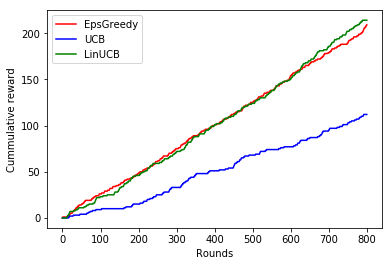

In [12]:
# Plot the running cumulative rewards of each MAB run offline
running_cum_reward_EpsGreedy = [0] * len(results_EpsGreedy)
running_cum_reward_UCB = [0] * len(results_UCB)
running_cum_reward_LinUCB = [0] * len(results_LinUCB)
for i in range(len(results_EpsGreedy)): # assumes all were run for same amount of rounds
    running_cum_reward_EpsGreedy[i] = sum(results_EpsGreedy[:i])
    running_cum_reward_UCB[i] = sum(results_UCB[:i])
    running_cum_reward_LinUCB[i] = sum(results_LinUCB[:i])

plt.plot(running_cum_reward_EpsGreedy, "r", label="EpsGreedy")
plt.plot(running_cum_reward_UCB, "b", label="UCB")
plt.plot(running_cum_reward_LinUCB, "g", label="LinUCB")
plt.xlabel("Rounds")
plt.ylabel("Cummulative reward")
plt.legend(loc='best')
plt.show()

### 4.B.

## 5. KernelUCB

In [13]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [14]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    

IndentationError: expected an indented block (<ipython-input-14-8163fcb89ddf>, line 25)